# Compute Homeomorphism on Circle

In [63]:
import torch

STATE_DIM = 2
LAMBDA = torch.tensor(2.0)
RHO = torch.tensor(0.5)
GOAL_STATE = torch.tensor([1, 0])

def symmetry_group(theta):
    return torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                         [torch.sin(theta), torch.cos(theta)]])

def reward_func(state):
    cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=torch.float32)
    return -state.T @ cost_matrix @ state

def compute_flow(H, g):
    return H @ g @ torch.inverse(H)

N_STEPS = 10000
STATE_SPACE_LOW = -2
STATE_SPACE_HIGH = 2
GROUP_SPACE_LOW = 0
GROUP_SPACE_HIGH = 2 * torch.pi

H_oracle = torch.tensor([
    [1 / torch.sqrt(LAMBDA.to(dtype=torch.float32)), 0],
    [0, 1 / torch.sqrt(RHO.to(dtype=torch.float32))]
], requires_grad=True)


def compute_diffeo(H_0_how: str,
                   sample_size_states: int,
                   sample_size_group: int,):
    """Computes a diffeomorphism that makes the reward function invariant to the symmetry group using functional invariance."""
    losses, frobenius_norms = [], []

    if H_0_how == "random":
        H_0 = torch.tensor(torch.randn((2,2)), requires_grad=True)
    elif H_0_how == "identity":
        H_0 = torch.tensor([[1.0, 0.0], [0.0, 1.0]], requires_grad=True)
    elif H_0_how == "oracle":
        H_0 = torch.tensor([[1 / torch.sqrt(LAMBDA.to(dtype=torch.float32)), 0],
                            [0, 1 / torch.sqrt(RHO.to(dtype=torch.float32))]], requires_grad=True)
    else:
        raise ValueError(f"Unknown H_0_how: {H_0_how}")

    H = H_0
    optimizer = torch.optim.SGD([H], lr=0.001)

    previous_loss = torch.inf
    for _ in range(N_STEPS):
        states = torch.rand(sample_size_states, STATE_DIM) * (STATE_SPACE_HIGH - STATE_SPACE_LOW) + STATE_SPACE_LOW
        group_elements = torch.rand(sample_size_group) * (GROUP_SPACE_HIGH - GROUP_SPACE_LOW) + GROUP_SPACE_LOW

        # Compute the flow
        loss = 0
        for state in states:
            state = state.view(-1, 1)
            for group_element in group_elements:
                g = symmetry_group(group_element)
                flow = compute_flow(H, g)

                base_rewards = reward_func(state)
                transformed_rewards = reward_func(flow @ state)
                loss += torch.norm(base_rewards - transformed_rewards)

        loss = loss / (sample_size_states * sample_size_group)
        if _ % 100 == 0:
            print(f'Iteration: {_}')
            print(f'Loss: {loss.item()}')
            print(f'H: {H}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        frobenius_norm = torch.linalg.norm(H - H_oracle, ord=2) # Frobenius norm


        if torch.abs(previous_loss - loss) < 1e-5:
            break
        previous_loss = loss

        losses.append(loss.item())
        frobenius_norms.append(frobenius_norm.item())
    return H, losses, frobenius_norms

H, losses, frobenius_norms = compute_diffeo(H_0_how="oracle", sample_size_states=100, sample_size_group=100)

Iteration: 0
Loss: 3.15023783059587e-07
H: tensor([[0.7071, 0.0000],
        [0.0000, 1.4142]], requires_grad=True)


KeyboardInterrupt: 

In [38]:
N_runs = 3
sample_sizes_states = [10, 15, 30, 45]
sample_sizes_groups = [10, 15, 30, 45]

all_losses = {}
all_frobenius_norms = {}
init_hows = ["random", "identity", "oracle"]

for sample_size_state, sample_size_group in zip(sample_sizes_states, sample_sizes_groups):
    for init_how in init_hows:
        all_losses[(sample_size_state, sample_size_group, init_how)] = []
        all_frobenius_norms[(sample_size_state, sample_size_group, init_how)] = []
        for run in range(N_runs):
            _, losses, frobenius_norms = compute_diffeo(H_0_how=init_how, sample_size_states=sample_size_state, sample_size_group=sample_size_group)
            all_losses[(sample_size_state, sample_size_group, init_how)].append(losses)
            all_frobenius_norms[(sample_size_state, sample_size_group, init_how)].append(frobenius_norms)

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_67467/1985917120.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_0 = torch.tensor(torch.randn((2,2)), requires_grad=True)


Iteration: 0
Loss: 0.6633806824684143
H: tensor([[-0.1346,  0.8410],
        [-1.3021, -0.3836]], requires_grad=True)
Iteration: 100
Loss: 0.008720355108380318
H: tensor([[-0.1798,  0.6913],
        [-1.3883, -0.3631]], requires_grad=True)
Iteration: 200
Loss: 0.007106252945959568
H: tensor([[-0.1804,  0.6920],
        [-1.3886, -0.3630]], requires_grad=True)
Iteration: 300
Loss: 0.007028239779174328
H: tensor([[-0.1830,  0.6950],
        [-1.3878, -0.3619]], requires_grad=True)
Iteration: 400
Loss: 0.012657573446631432
H: tensor([[-0.1808,  0.6919],
        [-1.3900, -0.3631]], requires_grad=True)
Iteration: 500
Loss: 0.0023040873929858208
H: tensor([[-0.1810,  0.6948],
        [-1.3892, -0.3632]], requires_grad=True)
Iteration: 600
Loss: 0.012418607249855995
H: tensor([[-0.1826,  0.6921],
        [-1.3912, -0.3626]], requires_grad=True)
Iteration: 700
Loss: 0.0017165112076327205
H: tensor([[-0.1812,  0.6952],
        [-1.3904, -0.3635]], requires_grad=True)
Iteration: 800
Loss: 0.005

KeyboardInterrupt: 

In [100]:
import torch

STATE_DIM = 2
LAMBDA = torch.tensor(2.0)
RHO = torch.tensor(0.5)
GOAL_STATE = torch.tensor([1, 0])

def symmetry_group(theta):
    return torch.stack([
        torch.stack([torch.cos(theta), -torch.sin(theta)], dim=-1),
        torch.stack([torch.sin(theta), torch.cos(theta)], dim=-1)
    ], dim=-2)  # Shape: (batch_size, 2, 2)

def reward_func(state):
    cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=torch.float32)
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

def compute_flow(H, g):
    return H @ g @ torch.inverse(H)

N_STEPS = 5000
STATE_SPACE_LOW = -2
STATE_SPACE_HIGH = 2
GROUP_SPACE_LOW = 0
GROUP_SPACE_HIGH = 2 * torch.pi

H_oracle = torch.tensor([
    [1 / torch.sqrt(LAMBDA.to(dtype=torch.float32)), 0],
    [0, 1 / torch.sqrt(RHO.to(dtype=torch.float32))]
], requires_grad=True)

def compute_diffeo(H_0_how: str,
                   sample_size: int,
                   verbose: bool = False):
    """Computes a diffeomorphism that makes the reward function invariant to the symmetry group using functional invariance."""
    losses, frobenius_norms = [], []

    if H_0_how == "random":
        H_0 = torch.nn.Parameter(torch.randn((2, 2), dtype=torch.float32))
    elif H_0_how == "identity":
        H_0 = torch.nn.Parameter(torch.eye(2, dtype=torch.float32))
    elif H_0_how == "oracle":
        H_0 = torch.nn.Parameter(H_oracle.clone())
    else:
        raise ValueError(f"Unknown H_0_how: {H_0_how}")

    optimizer = torch.optim.Adam([H_0], lr=0.0005)

    previous_loss = torch.inf
    previous_H = H_0
    for step in range(N_STEPS):
        # Sample states and group elements
        states = torch.rand((sample_size, STATE_DIM)) * (STATE_SPACE_HIGH - STATE_SPACE_LOW) + STATE_SPACE_LOW
        states = states.unsqueeze(-1)  # Shape: (batch_size, 2, 1) for column vectors

        group_elements = torch.rand(sample_size) * (GROUP_SPACE_HIGH - GROUP_SPACE_LOW) + GROUP_SPACE_LOW
        g_matrices = symmetry_group(group_elements)  # Shape: (batch_size, 2, 2)

        # Compute flow for all elements at once
        H_expanded = H_0.unsqueeze(0)  # Shape: (1, 2, 2)
        flow_matrices = H_expanded @ g_matrices @ torch.inverse(H_expanded)  # (batch_size, 2, 2)

        # Transform all states in a batch-wise manner
        transformed_states = torch.einsum('bij,bjk->bik', flow_matrices, states)

        # Compute rewards
        base_rewards = reward_func(states.squeeze(-1))  # Remove last dimension
        transformed_rewards = reward_func(transformed_states.squeeze(-1))

        loss = torch.mean(torch.pow(base_rewards - transformed_rewards, 2))

        if step % 100 == 0 and verbose:
            print(f'Iteration: {step}')
            print(f'Loss: {loss.item()}')
            print(f'H: {H_0}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute Frobenius norm
        frobenius_norm = torch.linalg.norm(H_0 - H_oracle, ord=2)

        losses.append(loss.item())
        frobenius_norms.append(frobenius_norm.item())

    return H_0, losses, frobenius_norms
compute_diffeo(H_0_how="oracle", sample_size=100, verbose=True)

Iteration: 0
Loss: 1.937317358402177e-13
H: Parameter containing:
tensor([[0.7071, 0.0000],
        [0.0000, 1.4142]], requires_grad=True)
Iteration: 100
Loss: 1.1067322613911301e-09
H: Parameter containing:
tensor([[ 7.0711e-01, -1.2026e-06],
        [-8.9969e-06,  1.4142e+00]], requires_grad=True)
Iteration: 200
Loss: 3.664474322942479e-13
H: Parameter containing:
tensor([[ 7.0711e-01,  2.6048e-06],
        [-5.1901e-06,  1.4142e+00]], requires_grad=True)
Iteration: 300
Loss: 4.360978266872151e-13
H: Parameter containing:
tensor([[ 7.0711e-01,  2.6374e-06],
        [-5.1575e-06,  1.4142e+00]], requires_grad=True)
Iteration: 400
Loss: 5.025902112022751e-13
H: Parameter containing:
tensor([[ 7.0711e-01,  2.5498e-06],
        [-5.2450e-06,  1.4142e+00]], requires_grad=True)
Iteration: 500
Loss: 3.0001389285209956e-13
H: Parameter containing:
tensor([[ 7.0711e-01,  2.6047e-06],
        [-5.1902e-06,  1.4142e+00]], requires_grad=True)
Iteration: 600
Loss: 3.5596707330907973e-13
H: Paramet

(Parameter containing:
 tensor([[ 7.0719e-01,  4.2679e-07],
         [-8.8853e-07,  1.4144e+00]], requires_grad=True),
 [1.937317358402177e-13,
  3.23915301123634e-05,
  2.518950395824504e-06,
  8.759910997468978e-06,
  1.8695742255658843e-05,
  1.2724447515211068e-05,
  6.600659162359079e-06,
  8.602120828982152e-07,
  4.333910965215182e-06,
  9.242927262675948e-06,
  8.319929293065798e-06,
  3.5633538573165424e-06,
  3.2000883720684214e-07,
  1.3360305501919356e-06,
  4.382199676911114e-06,
  6.490692157967715e-06,
  4.477346465137089e-06,
  1.6404642337874975e-06,
  7.243502295750659e-07,
  3.1273461900127586e-06,
  3.6193089272273937e-06,
  3.01713089356781e-06,
  1.6120579857670236e-06,
  8.819300205686886e-07,
  1.1161546353832819e-06,
  1.8857797385862796e-06,
  1.388014879921684e-06,
  1.1590429949137615e-06,
  7.856347110646311e-07,
  9.62035073825973e-07,
  1.0841929451999022e-06,
  6.824154183959763e-07,
  3.0225865543798136e-07,
  3.086327069468098e-07,
  5.558174507314106e

In [120]:
N_runs = 25
sample_sizes = [8, 32, 64, 96, 128, 194, 256, 384, 512]

all_losses = {}
all_frobenius_norms = {}
init_hows = ["random", "identity", "oracle"]
init_hows = ["random"]
for sample_size in sample_sizes:
    for init_how in init_hows:
        print(f"Running sample size: {sample_size}, initialization: {init_how}")
        run_name = f"sample_size_{sample_size}_init_{init_how}"
        all_losses[run_name] = []
        all_frobenius_norms[run_name] = []
        for run in range(N_runs):
            _, losses, frobenius_norms = compute_diffeo(H_0_how=init_how, sample_size=sample_size)
            all_losses[run_name].append(losses)
            all_frobenius_norms[run_name].append(frobenius_norms)

Running sample size: 8, initialization: random
Running sample size: 32, initialization: random
Running sample size: 64, initialization: random
Running sample size: 96, initialization: random
Running sample size: 128, initialization: random
Running sample size: 194, initialization: random
Running sample size: 256, initialization: random
Running sample size: 384, initialization: random
Running sample size: 512, initialization: random


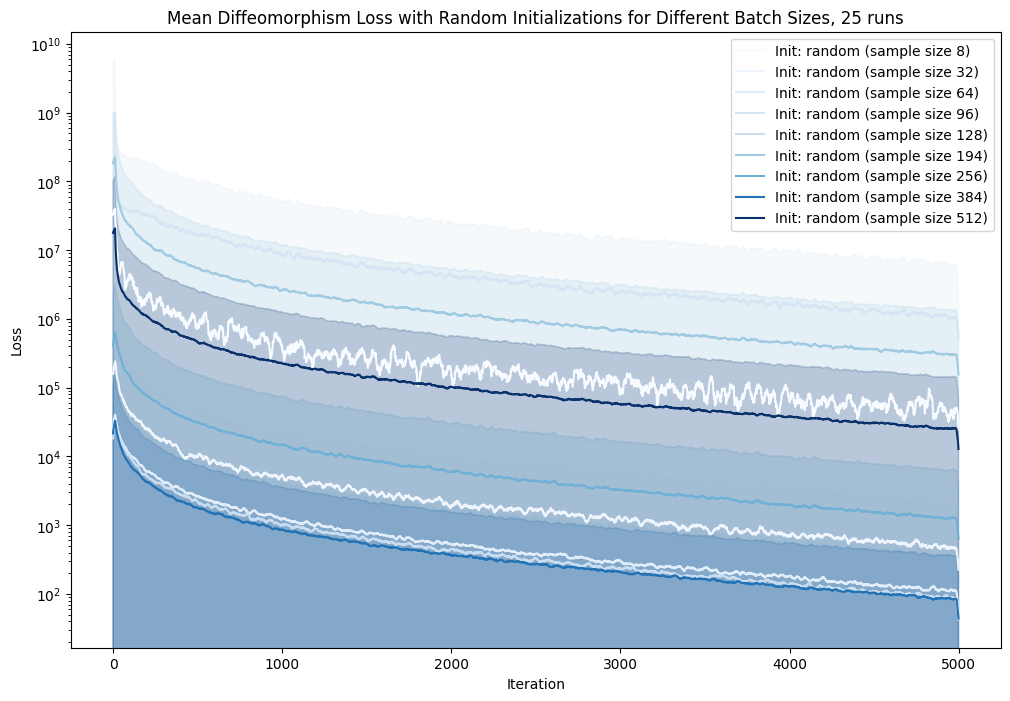

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def moving_average(arr, window_size):
    kernel = np.ones(window_size) / window_size
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=arr)

unique_inits = list(set(init_hows))
unique_sample_sizes = sorted(list(set(sample_sizes)))
WINDOW_SIZE = 25

plot_inits = ["random"]
plot_sample_sizes = [8, 32, 64, 96, 128, 194, 256, 384, 512]

plt.figure(figsize=(12, 8))
cmap = cm.Blues
norm = plt.Normalize(min(plot_sample_sizes), max(plot_sample_sizes))

for idx_init, init in enumerate(plot_inits):
    for i, sample_size in enumerate(plot_sample_sizes):
        run_name = f"sample_size_{sample_size}_init_{init}"
        if run_name in all_losses:
            losses = all_losses[run_name]
            losses_array = np.array(losses)
            losses_smoothed = moving_average(losses_array, WINDOW_SIZE)
            mean_losses = np.mean(losses_smoothed, axis=0)
            std_losses = np.std(losses_smoothed, axis=0)
            color = cmap(norm(sample_size))
            plt.plot(mean_losses, label=f'Init: {init} (sample size {sample_size})', color=color)
            plt.yscale('log')
            plt.fill_between(range(len(mean_losses)), mean_losses - std_losses, mean_losses + std_losses, alpha=0.2, color=color)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Mean Diffeomorphism Loss with Random Initializations for Different Batch Sizes, {N_runs} runs')
plt.legend()
plt.show()


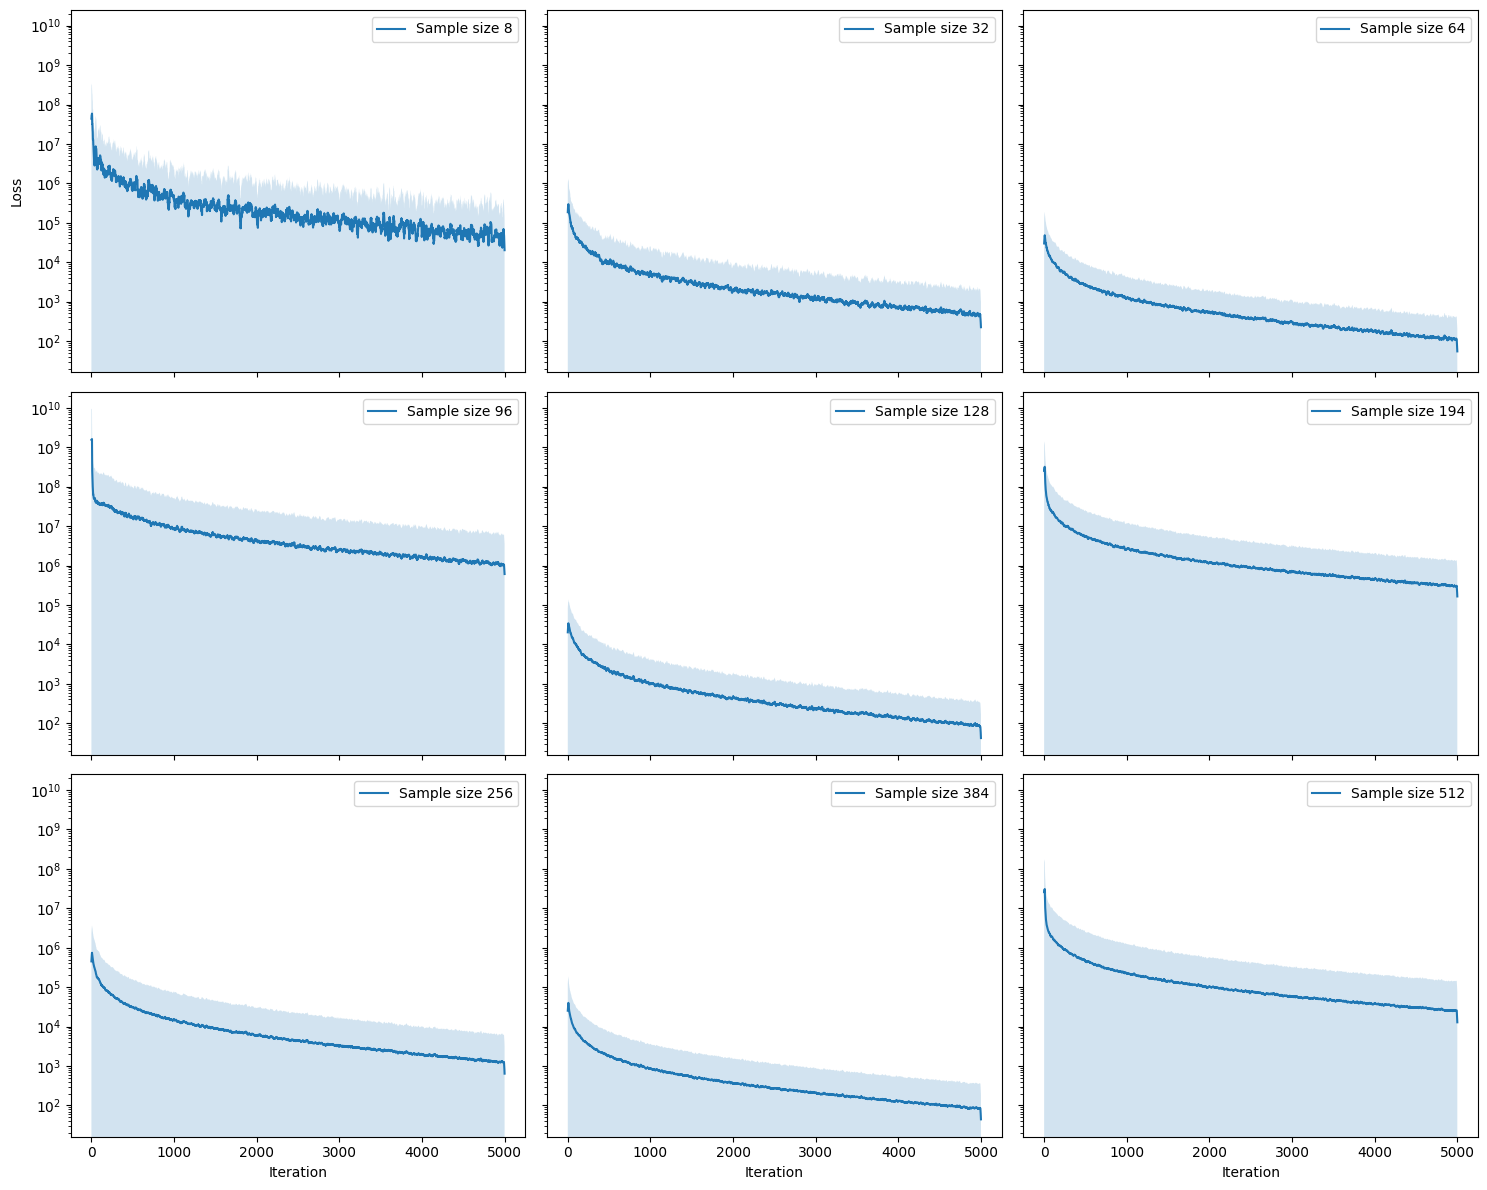

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def moving_average(arr, window_size):
    kernel = np.ones(window_size) / window_size
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=arr)

unique_inits = list(set(init_hows))
unique_sample_sizes = sorted(list(set(sample_sizes)))
WINDOW_SIZE = 15

plot_inits = ["random"]
plot_sample_sizes = [8, 32, 64, 96, 128, 194, 256, 384, 512]

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharey=True, sharex=True)
cmap = cm.Blues
norm = plt.Normalize(min(plot_sample_sizes) * 0.5, max(plot_sample_sizes))

for i, sample_size in enumerate(plot_sample_sizes):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    run_name = f"sample_size_{sample_size}_init_random"
    if run_name in all_losses:
        losses = all_losses[run_name]
        losses_array = np.array(losses)
        losses_smoothed = moving_average(losses_array, WINDOW_SIZE)
        mean_losses = np.mean(losses_smoothed, axis=0)
        std_losses = np.std(losses_smoothed, axis=0)
        color = cmap(norm(sample_size))
        ax.plot(mean_losses, label=f'Sample size {sample_size}')
        ax.set_yscale('log')
        ax.fill_between(range(len(mean_losses)), mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)
        if row==2:
            ax.set_xlabel('Iteration')
        ax.legend()

for i in range(len(plot_sample_sizes), 9):
    fig.delaxes(axes.flatten()[i])

axes[0, 0].set_ylabel('Loss')

plt.tight_layout()
plt.show()


## Gradient Level Diffeomorphic Optimization

In [213]:
import torch

def compute_diffeomorphic_flow(H):
    """Returns a function that computes the transformed vector field given states s."""
    generator = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
    return H @ generator @ torch.inverse(H)

def flow_func(vector_field):
    """Returns a function that applies a vector field to a state."""
    return lambda s: torch.matmul(vector_field, s)

def compute_jacobian(f, s):
    """Compute a vectorized Jacobian of function f over a batch of states s."""
    return torch.vmap(torch.func.jacrev(f))(s)

def compute_lie_bracket(H, s, kernel_dist):
    """Compute the Lie bracket [X, Y] given a diffeomorphism H and kernel distribution."""
    batch_size = s.shape[0]
    diffeo_flow = compute_diffeomorphic_flow(H)

    # Compute vector fields at s
    batched_diffeo_vector_field = diffeo_flow.expand(batch_size, -1, -1)
    batched_kernel_dist = kernel_dist.expand(batch_size, -1, -1)
    diffeo_vector_field = torch.bmm(batched_diffeo_vector_field, s.unsqueeze(-1))
    kernel_dist_vector_field = torch.bmm(batched_kernel_dist, s.unsqueeze(-1))

    # Compute Jacobians (vectorized)
    diffeo_callable = flow_func(diffeo_flow)
    kernel_callable = flow_func(kernel_dist)

    J_diffeo = compute_jacobian(diffeo_callable, s).transpose(-1, -2)  # Shape: (batch_size, 2, 2), must be transposed due to jacrev
    J_kernel = compute_jacobian(kernel_callable, s).transpose(-1, -2)  # Shape: (batch_size, 2, 2), must be transposed due to jacrev

    # Compute Lie bracket: [X, Y] = J_X @ Y_vals - J_Y @ X_vals
    bracket = torch.bmm(J_diffeo, kernel_dist_vector_field) - torch.bmm(J_kernel, diffeo_vector_field)

    return bracket  # Shape: (batch_size, 2, 1)

def lie_bracket_loss(lie_bracket):
    """Compute the loss for the Lie bracket."""
    return torch.norm(lie_bracket)

In [214]:
s_points = torch.tensor([[2.0, 1.0], [1.0, -1.0], [3.0, 1.5]], dtype=torch.float32) # Shape: (batch_size, state_dim)
LAMBDA = torch.tensor(2.0)
RHO = torch.tensor(0.5)

H_oracle = torch.tensor([
    [1 / torch.sqrt(LAMBDA.to(dtype=torch.float32)), 0],
    [0, 1 / torch.sqrt(RHO.to(dtype=torch.float32))]
], requires_grad=True)

H_0 = torch.eye(2, dtype=torch.float32)
H_0 = H_oracle

def compute_kernel_distribution(lambda_, rho):
    """Kernel Distribution of R at points s with parameters lambda and rho."""
    kernel_dist = torch.tensor([[-lambda_, 0], [0, rho]], dtype=torch.float32)
    return kernel_dist

kernel_dist = compute_kernel_distribution(lambda_=LAMBDA, rho=RHO)
lie_bracket_result = compute_lie_bracket(H=H_0, s=s_points, kernel_dist=kernel_dist)

## Find Diffeomorphic Flow via Functional Invariance and Vector Field Invariance

In [71]:
from tqdm.notebook import tqdm
import torch

STATE_DIM = 2
LAMBDA = torch.tensor(2.0)
RHO = torch.tensor(0.5)
GOAL_STATE = torch.tensor([1, 0])

def symmetry_group(theta):
    return torch.stack([
        torch.stack([torch.cos(theta), -torch.sin(theta)], dim=-1),
        torch.stack([torch.sin(theta), torch.cos(theta)], dim=-1)
    ], dim=-2)  # Shape: (batch_size, 2, 2)

def reward_func(state):
    cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=torch.float32)
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

def compute_flow(H, g):
    return H @ g @ torch.inverse(H)

N_STEPS = 5000
STATE_SPACE_LOW = -2
STATE_SPACE_HIGH = 2
GROUP_SPACE_LOW = 0
GROUP_SPACE_HIGH = 2 * torch.pi

H_oracle = torch.tensor([
    [1 / torch.sqrt(LAMBDA.to(dtype=torch.float32)), 0],
    [0, 1 / torch.sqrt(RHO.to(dtype=torch.float32))]
], requires_grad=True)

class DiffeomorphicFlow():
    def __init__(self, 
                 H_0_how: str,
                 symmetry_group: callable,
                 reward_function: callable,
                 differential_generator: torch.tensor,
                 kernel_distribution: torch.tensor,
                 sample_size: int,
                 n_epochs: int,
                 n_runs: int,
                 lambda_coeff: float = 0.0,
                 H_oracle: torch.tensor = None,
                 state_dim = 2,
                 state_space_high = 2,
                 state_space_low = -2,
                 group_space_high = 2 * torch.pi,
                 group_space_low = 0,
                 verbose: bool = False):
        """Computes a diffeomorphism that makes a reward function invariant to a symmetry group using functional and vector field invariance."""

        if H_0_how == "random":
            self.H_func_inv = torch.nn.Parameter(torch.randn((2,2), dtype=torch.float32))
            self.H_vec_field = torch.nn.Parameter(torch.randn((2,2), dtype=torch.float32))
        elif H_0_how == "identity":
            self.H_func_inv = torch.nn.Parameter(torch.eye(2, dtype=torch.float32))
            self.H_vec_field = torch.nn.Parameter(torch.eye(2, dtype=torch.float32))       
        elif H_0_how == "oracle":
            self.H_func_inv = torch.nn.Parameter(H_oracle.clone())
            self.H_vec_field = torch.nn.Parameter(H_oracle.clone())      

        else:
            raise ValueError(f"Unknown H_0_how: {H_0_how}")

        self.H_0_how = H_0_how
        self.symmetry_group = symmetry_group
        self.reward_function = reward_function
        self.differential_generator = differential_generator
        self.kernel_distribution = kernel_distribution
        self.lambda_coeff = lambda_coeff
        self.H_oracle = H_oracle
        self.n_epochs = n_epochs
        self.n_runs = n_runs
        self._sample_size = sample_size
        self._verbose = verbose
        self.state_dim = state_dim
        self.state_space_high = state_space_high
        self.state_space_low = state_space_low
        self.group_space_high = group_space_high
        self.group_space_low = group_space_low

        self._optimizer_func = torch.optim.Adam([self.H_func_inv], lr=0.0005)
        self._optimizer_vec_field = torch.optim.Adam([self.H_vec_field], lr=0.0005)

    def reset_parameters(self):
        """Resets the Diffeomorphisms."""

        if self.H_0_how == "random":
            initial_H = torch.randn((2,2), dtype=torch.float32)
            self.H_func_inv = torch.nn.Parameter(initial_H.clone().detach().requires_grad_(True))
            self.H_vec_field = torch.nn.Parameter(initial_H.clone().detach().requires_grad_(True))
        elif self.H_0_how == "identity":
            self.H_func_inv = torch.nn.Parameter(torch.eye(2, dtype=torch.float32), requires_grad=True)
            self.H_vec_field = torch.nn.Parameter(torch.eye(2, dtype=torch.float32), requires_grad=True)       
        elif self.H_0_how == "oracle":
            self.H_func_inv = torch.nn.Parameter(H_oracle.clone(), requires_grad=True)
            self.H_vec_field = torch.nn.Parameter(H_oracle.clone(), requires_grad=True)

        del self._optimizer_func, self._optimizer_vec_field
        self._optimizer_func = torch.optim.Adam([self.H_func_inv], lr=0.0005)
        self._optimizer_vec_field = torch.optim.Adam([self.H_vec_field], lr=0.0005)  


    def compute_diffeomorphic_flow(self,
                                   H: torch.tensor,
                                   flow: torch.tensor) -> torch.tensor:
        """Given a flow and a diffeomorphism H, computes H \circ flow \circ H^-1."""
        return H @ flow @ torch.inverse(H)


    def functional_optimization(self,
                                H: torch.tensor,
                                lambda_coeff: float,
                                take_gradient_step: bool,
                                states: torch.Tensor,
                                group_elements: torch.Tensor) -> float:
        """Takes one gradient step to computes a Diffeomorphism that makes the reward function invariant to the symmetry group using functional invariance. Adds a
        regularizer that drives the Homeo towards the identity matrix."""

        states = states.unsqueeze(-1)

        group_actions = self.symmetry_group(group_elements)

        H_expanded = H.unsqueeze(0)
        flow_matrices = self.compute_diffeomorphic_flow(H_expanded, group_actions)
        transformed_states = torch.einsum('bij,bjk->bik', flow_matrices, states)

        base_rewards = self.reward_function(states.squeeze(-1))
        transformed_rewards = self.reward_function(transformed_states.squeeze(-1))

        loss = torch.mean(torch.pow(base_rewards - transformed_rewards, 2)) + lambda_coeff * torch.norm(H - torch.eye(H.shape[0]))

        if take_gradient_step:
            self._optimizer_func.zero_grad()
            loss.backward()
            self._optimizer_func.step()

        return loss


    def vector_field_optimization(self,
                                  states: torch.tensor) -> float:
        
        def flow_func(vector_field):
            """Returns a function that applies a vector field to a state."""
            return lambda s: torch.matmul(vector_field, s)

        def compute_jacobian(f, s):
            """Compute a vectorized Jacobian of function f over a batch of states s."""
            return torch.vmap(torch.func.jacrev(f))(s)
        
        batch_size = states.shape[0]
        diffeo_flow = self.compute_diffeomorphic_flow(self.H_vec_field, self.differential_generator)

        # Compute vector fields at s
        batched_diffeo_vector_field = diffeo_flow.expand(batch_size, -1, -1)
        batched_kernel_dist = self.kernel_distribution.expand(batch_size, -1, -1)
        diffeo_vector_field = torch.bmm(batched_diffeo_vector_field, states.unsqueeze(-1))
        kernel_dist_vector_field = torch.bmm(batched_kernel_dist, states.unsqueeze(-1))

        # Compute Jacobians (vectorized)
        diffeo_callable = flow_func(diffeo_flow)
        kernel_callable = flow_func(self.kernel_distribution)

        J_diffeo = compute_jacobian(diffeo_callable, states).transpose(-1, -2)  # Shape: (batch_size, 2, 2), must be transposed due to jacrev
        J_kernel = compute_jacobian(kernel_callable, states).transpose(-1, -2)  # Shape: (batch_size, 2, 2), must be transposed due to jacrev

        # Compute Lie bracket: [X, Y] = J_X @ Y_vals - J_Y @ X_vals
        bracket = torch.bmm(J_diffeo, kernel_dist_vector_field) - torch.bmm(J_kernel, diffeo_vector_field)
        loss = torch.norm(bracket)

        self._optimizer_vec_field.zero_grad()
        loss.backward()
        self._optimizer_vec_field.step()

        return loss
    
    def take_one_step(self):
        """Take one gradient step via both functional and vector field invariance."""

        # Gradient based update
        states = torch.rand(self._sample_size, self.state_dim) * (self.state_space_high - self.state_space_low) + self.state_space_low
        group_elements = torch.rand(self._sample_size) * (self.group_space_high - self.group_space_low) + self.group_space_low

        _ = self.functional_optimization(self.H_func_inv, lambda_coeff=self.lambda_coeff, take_gradient_step=True, states=states, group_elements=group_elements)
        _ = self.vector_field_optimization(states=states)
        del states, group_elements

        # Evaluation
        eval_states = torch.rand(self._sample_size, self.state_dim) * (self.state_space_high - self.state_space_low) + self.state_space_low
        eval_group_elements = torch.rand(self._sample_size) * (self.group_space_high - self.group_space_low) + self.group_space_low
        
        loss_func = self.functional_optimization(self.H_func_inv, lambda_coeff=0, take_gradient_step=False, states=eval_states, group_elements=eval_group_elements)
        loss_vec_field = self.functional_optimization(self.H_vec_field, lambda_coeff=0, take_gradient_step=False, states=eval_states, group_elements=eval_group_elements)
        if self.H_oracle is not None:
            loss_oracle = self.functional_optimization(self.H_oracle, lambda_coeff=0, take_gradient_step=False, states=eval_states, group_elements=eval_group_elements)
        else:
            loss_oracle = torch.tensor(0.0)

        return loss_func, loss_vec_field, loss_oracle
    
    def optimize(self):

        self.loss_funcs = torch.zeros((self.n_runs, self.n_epochs))
        self.loss_vec_fields = torch.zeros((self.n_runs, self.n_epochs))
        self.loss_oracles = torch.zeros((self.n_runs, self.n_epochs))


        for idx_run in range(self.n_runs):
            self.reset_parameters()
            pbar = tqdm(range(self.n_epochs), desc=f'Run {idx_run + 1}/{self.n_runs}', dynamic_ncols=True, ascii=True)
            for idx_epoch in pbar:
                loss_func, loss_vec_field, loss_oracle = self.take_one_step()
                self.loss_funcs[idx_run, idx_epoch] = loss_func
                self.loss_vec_fields[idx_run, idx_epoch] = loss_vec_field
                self.loss_oracles[idx_run, idx_epoch] = loss_oracle

                if idx_epoch % 250 == 0:
                    pbar.set_postfix({
                        'func. inv loss': f'{loss_func:.4f}',
                        'vec. field inv loss': f'{loss_vec_field:.4f}',
                        'oracle loss': f'{loss_oracle:.4f}'
                    })
            pbar.close()



            if self._verbose and idx_epoch % 100 == 0:
                print(f'Run: {idx_run}, Epoch: {idx_epoch}')
                print(f'Loss Func: {loss_func.item()}, Loss Vec Field: {loss_vec_field.item()}, Loss Oracle: {loss_oracle.item()}')

In [77]:
LAMBDA = torch.tensor(2.0)
RHO = torch.tensor(0.5)
SAMPLE_SIZE = 25
N_EPOCHS = 25_000
N_RUNS = 5

def symmetry_group(theta):
    return torch.stack([
        torch.stack([torch.cos(theta), -torch.sin(theta)], dim=-1),
        torch.stack([torch.sin(theta), torch.cos(theta)], dim=-1)
    ], dim=-2)  # Shape: (batch_size, 2, 2)
def reward_func(state):
    cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=torch.float32)
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)
differential_generator = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
kernel_distribution = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=torch.float32)
H_oracle = torch.tensor([[1 / torch.sqrt(LAMBDA), 0], [0, 1 / torch.sqrt(RHO)]], dtype=torch.float32)

diffeo_flow = DiffeomorphicFlow(H_0_how="random",
                                symmetry_group=symmetry_group,
                                reward_function=reward_func,
                                differential_generator=differential_generator,
                                kernel_distribution=kernel_distribution,
                                sample_size=SAMPLE_SIZE,
                                n_epochs=N_EPOCHS,
                                n_runs=N_RUNS,
                                H_oracle=H_oracle)

diffeo_flow.optimize()

Run 1/5:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 2/5:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 3/5:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 4/5:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 5/5:   0%|          | 0/25000 [00:00<?, ?it/s]

## Plotting

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Global settings for font size and tick size
TICK_SIZE = 20
LABEL_FONT_SIZE = 20
PLOT_ORACLE: bool = True
WINDOW_SIZE = 5

plt.rcParams.update({
    'xtick.labelsize': TICK_SIZE,
    'ytick.labelsize': TICK_SIZE,
    'axes.labelsize': LABEL_FONT_SIZE,
    'legend.fontsize': LABEL_FONT_SIZE
})

def compute_mean_and_std_losses(diffeo_flow):
    """"""

    def moving_average(arr, window_size):
        kernel = np.ones(window_size) / window_size
        return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=arr)
    
    def compute_mean_and_std_loss(losses):
        losses_np = losses.detach().numpy()
        mean_losses_smoothed = moving_average(losses_np, WINDOW_SIZE).mean(axis=0)
        log_std_losses_smoothed = np.exp(np.std(np.log(moving_average(losses_np, WINDOW_SIZE) + 1e-8), axis=0))
        return mean_losses_smoothed, log_std_losses_smoothed
    
    loss_funcs = diffeo_flow.loss_funcs
    loss_vec_fields = diffeo_flow.loss_vec_fields
    loss_oracles = diffeo_flow.loss_oracles

    mean_loss_funcs, log_std_loss_funcs = compute_mean_and_std_loss(loss_funcs)
    mean_loss_vec_fields, log_std_loss_vec_fields = compute_mean_and_std_loss(loss_vec_fields)
    mean_loss_oracles, log_std_loss_oracles = compute_mean_and_std_loss(loss_oracles)

    losses = {}
    losses['loss_func'] = {}
    losses['loss_vec_field'] = {}
    losses['loss_oracle'] = {}

    losses['loss_func']['mean'] = mean_loss_funcs
    losses['loss_func']['log_std'] = log_std_loss_funcs
    losses['loss_vec_field']['mean'] = mean_loss_vec_fields
    losses['loss_vec_field']['log_std'] = log_std_loss_vec_fields
    losses['loss_oracle']['mean'] = mean_loss_oracles
    losses['loss_oracle']['log_std'] = log_std_loss_oracles

    return losses

def plot_losses(losses):

    plt.figure(figsize=(12, 8))
    loss_types = ['loss_func', 'loss_vec_field', 'loss_oracle']
    loss_names = ['Functional Invariance', 'Vector Field Invariance', 'Oracle']
    colors = ['blue', 'green', 'red']

    for idx_loss_type, loss_type in enumerate(loss_types):
        mean_losses = losses[loss_type]['mean']
        log_std_losses = losses[loss_type]['log_std']
        plt.plot(mean_losses, label=loss_names[idx_loss_type], color=colors[idx_loss_type])
        plt.fill_between(range(len(mean_losses)), mean_losses / log_std_losses, mean_losses * log_std_losses, alpha=0.2, color=colors[idx_loss_type])


    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

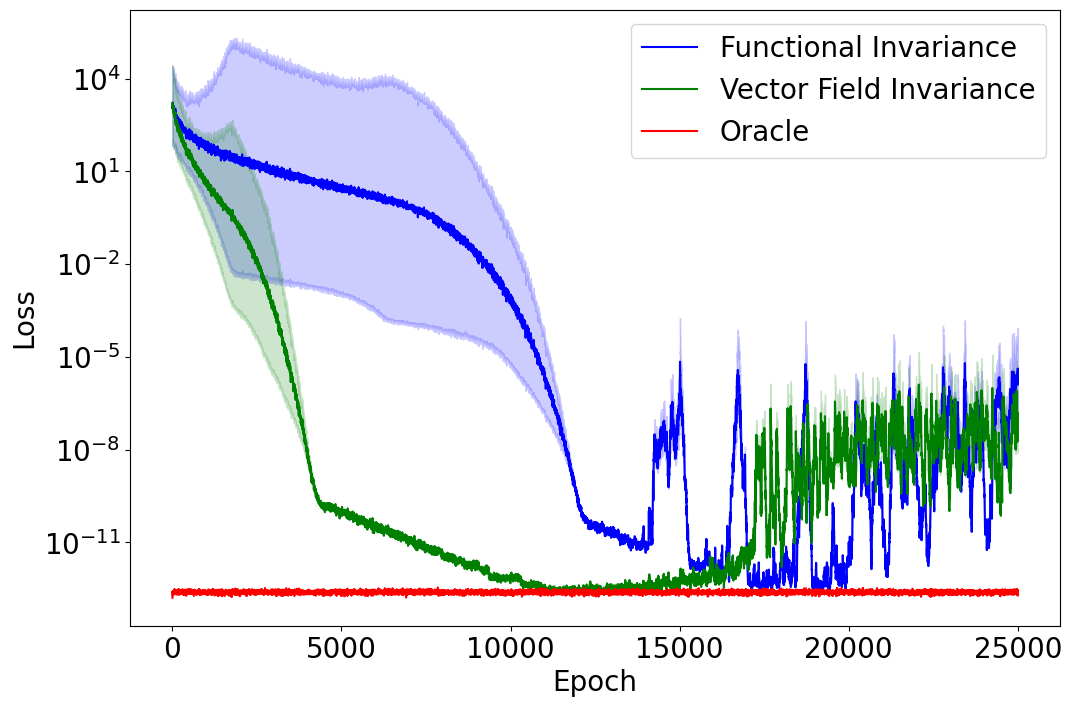

In [78]:
losses = compute_mean_and_std_losses(diffeo_flow)
plot_losses(losses)

## Compare Different Regularization Coefficients for Functional Invariance.

In [6]:
LAMBDA_COEFFS = [0]

diffeo_flows = []

for lambda_coeff in LAMBDA_COEFFS:
    print(f"Running for lambda coeff: {lambda_coeff}")
    diffeo_flow = DiffeomorphicFlow(H_0_how="random",
                                    symmetry_group=symmetry_group,
                                    reward_function=reward_func,
                                    differential_generator=differential_generator,
                                    kernel_distribution=kernel_distribution,
                                    sample_size=SAMPLE_SIZE,
                                    n_epochs=N_EPOCHS,
                                    n_runs=N_RUNS,
                                    H_oracle=H_oracle,
                                    lambda_coeff=lambda_coeff)

    diffeo_flow.optimize()
    diffeo_flows.append(diffeo_flow)

Running for lambda coeff: 0
Running for lambda coeff: 0.001
Running for lambda coeff: 0.005
Running for lambda coeff: 0.01
